# **Introduction to Deep Learning: Final Project**

**Submitted by:**

Roei Matz       205871478

Yotam Silverman 313532418

# Project Description

The data for this project was gathered from the [sign language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset from the website kaggle.com.


The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

Our project's objective is to design and build a neural network that will identify the letters given in each image.

In [15]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

# CapsNet related imports
# clone package repository
!git clone https://github.com/XifengGuo/CapsNet-Keras.git

# navigate to atalaia directory
%cd capsnet-keras

# get modifications made on the repo
!git pull origin master

# install package
!python setup.py install

# import it
import tensorflow as tf
import keras
import keras.backend as K

from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
#

import torch.optim as optim

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

Cloning into 'CapsNet-Keras'...
remote: Enumerating objects: 235, done.
remote: Total 235 (delta 0), reused 0 (delta 0), pack-reused 235
Receiving objects: 100% (235/235), 1.06 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (117/117), done.
[Errno 2] No such file or directory: 'capsnet-keras'
/content/capsnet-keras
From https://github.com/XifengGuo/CapsNet-Keras
 * branch            master     -> FETCH_HEAD
Already up to date.
python3: can't open file 'setup.py': [Errno 2] No such file or directory


Mount Google Drive and load the project's data:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
train_csv = open('/content/gdrive/My Drive/DL/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/DL/sign_mnist_test.csv')
x_train = np.genfromtxt(train_csv, delimiter=',')[1:,1:]
x_test = np.genfromtxt(test_csv, delimiter=',')[1:,1:]

train_csv = open('/content/gdrive/My Drive/DL/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/DL/sign_mnist_test.csv')
t_train = np.genfromtxt(train_csv, delimiter=',')[1:,0]
t_test =  np.genfromtxt(test_csv, delimiter=',')[1:,0]


Mounted at /content/gdrive


Here we show few examples of the letters notions in the sign language:

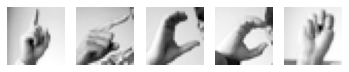

In [3]:
i = 0
plt.figure(figsize=(6, 3))
for img in x_train: 
  plt.subplot(1, 5, i + 1)
  img = np.reshape(img, (28, 28))
  plt.imshow(img, cmap='Greys_r')
  plt.axis('off');
  i += 1
  if i == 5:
    break

Normalizing the data set:

In [4]:
def img_norm(data):
  output = []
  for img in data: 
    img = (img - np.mean(img))/np.std(img)
    output.append(np.array(img))
  return np.array(output)

x_train_norm = img_norm(x_train)
x_test_norm = img_norm(x_test)

In [5]:
train_loader = torch.utils.data.DataLoader(
    np.concatenate((t_train[:,None], x_train_norm),axis=1),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    np.concatenate((t_test[:,None], x_test_norm),axis=1),
    batch_size=1000, shuffle=True)

Defining CNN

In [6]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


def train(epoch, model, lr=0.01, momentum=0.5, perm=torch.arange(0, 784).long()):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for batch_idx, ar in enumerate(train_loader):
        data = ar[:,1:]
        label = ar[:,0]
        # send to device
        data, label = data.to(device), label.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, label.long())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) 
            

accuracy_list = []

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for ar in test_loader:
        data = ar[:,1:]
        label = ar[:,0]
        # send to device
        data, label = data.to(device), label.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, label.long(), reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))   

In [7]:
# Training settings 
n_features = 10 # number of feature maps

input_size  = 28*28   # images are 28x28 pixels
output_size = 26      # there are 26 classes

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

lr = 0.001
momentum = 0.1

for epoch in range(0, 6):
    train(epoch, model_cnn.double(), lr)
test(model_cnn)

Train Epoch: 0 [0/27455 (0%)]	Loss: 3.273212
Train Epoch: 0 [6400/27455 (23%)]	Loss: 1.236286
Train Epoch: 0 [12800/27455 (47%)]	Loss: 0.634972
Train Epoch: 0 [19200/27455 (70%)]	Loss: 0.393732
Train Epoch: 0 [25600/27455 (93%)]	Loss: 0.238706
Train Epoch: 1 [0/27455 (0%)]	Loss: 0.165967
Train Epoch: 1 [6400/27455 (23%)]	Loss: 0.200866
Train Epoch: 1 [12800/27455 (47%)]	Loss: 0.082935
Train Epoch: 1 [19200/27455 (70%)]	Loss: 0.050602
Train Epoch: 1 [25600/27455 (93%)]	Loss: 0.019439
Train Epoch: 2 [0/27455 (0%)]	Loss: 0.039789
Train Epoch: 2 [6400/27455 (23%)]	Loss: 0.023786
Train Epoch: 2 [12800/27455 (47%)]	Loss: 0.055425
Train Epoch: 2 [19200/27455 (70%)]	Loss: 0.008960
Train Epoch: 2 [25600/27455 (93%)]	Loss: 0.044574
Train Epoch: 3 [0/27455 (0%)]	Loss: 0.021043
Train Epoch: 3 [6400/27455 (23%)]	Loss: 0.003464
Train Epoch: 3 [12800/27455 (47%)]	Loss: 0.005511
Train Epoch: 3 [19200/27455 (70%)]	Loss: 0.003650
Train Epoch: 3 [25600/27455 (93%)]	Loss: 0.001587
Train Epoch: 4 [0/27455 